# Modular CerberusTS Experimentation

First we make sure we are in the base working directory (this is probably not necessary if using the package):

Google Colab notebooks come with most of the packages we need, but we need to upgrade pandas and install accelerate.

Then we import the necessary CerberusTS modules.

In [1]:
import torch
# Check if CUDA is available
if torch.cuda.is_available():
    # Print the number of available CUDA devices
    print(f"Number of CUDA devices available: {torch.cuda.device_count()}")

    # Print each CUDA device
    for i in range(torch.cuda.device_count()):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")

Number of CUDA devices available: 1
CUDA Device 0: NVIDIA GeForce GTX 1650 with Max-Q Design


In [2]:
from cerberus_ts import CerberusConfig
CerberusConfig.set_masked_norm_zero = True
CerberusConfig.processor_type = 'flatten'
CerberusConfig.foresight_residual = False

c:\Users\johnm\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from cerberus_ts import Cerberus, train_cerberus
from cerberus_ts import Foresight, train_foresight
from cerberus_ts import TimeseriesDataPreparer, ResponseGenerator

import pandas as pd

Here we have the ability to do some custom configuration:

## Dataset Loading

Next we need a Pandas Dataframe of some wide-formatted mutlivariate timeseries data. Here we will use the Jena Climate Data found here: https://www.kaggle.com/datasets/mnassrib/jena-climate

In [4]:
df = pd.read_csv(r"../data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'],
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
# For these tests we will just use a small slice of the dataset
df = df.iloc[:5000,:]

## User Argument Specification
There are a number of different arguments that can be provided to Cerberus, shown below:

In [5]:
# What ratio of data needs to be available for the various call, response, and context windows to use that timestamp?
thresholds = {
    'call': 1,
    'response': 1,
    'context_0': 1,
    'context_1': 1,
    'context_2': 1
}

# How big should the call, context(s), and response windows be?
sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

# What timestep should each head use?
window_timesteps = {
    'call': '10T',
    'response': '10T',
    'context_0': '1H',
    'context_1': '2H',
    'context_2': '6H'
}

# Which columns should be used for each head?
feature_indexes = {
    'call': range(0,14),
    'response': [0, 1, 4],
    'context_0': range(0,14),
    'context_1': range(0,14),
    'context_2': range(0,14)
}

## Prepare Dataset

We will use CerberusTS's TimeseriesDataPreparer class to create Torch dataloaders for all our different heads, scaled, downsampled, and coil-normalized for easy Cerberus use.

In [6]:
# Initialize the preparer
preparer = TimeseriesDataPreparer(df, sizes, thresholds, feature_indexes, window_timesteps, train_len = 20_000, feature_range = (0, 1), batch_size = 64)

# Prepare the data
preparer.prepare_data()

In [7]:
next(iter(preparer.dataloaders[0]))[0].device

device(type='cuda', index=0)

## Foresight Training

First, we can optionally train Foresight to aid CerberusTS:

In [8]:
foresight = Foresight(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=512,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [512, 256],
                 dropout_rate = 0.0,
                 eventualities = 10,
                 expander_sizes = [256, 512],
                 out_channels = 128,
                 kernel_size = 3)

In [9]:
foresight = train_foresight(foresight, preparer.dataloaders, num_epochs = 30)

Epoch [1/30], Loss: 0.00993436680366786
Epoch [2/30], Loss: 0.00621493720906738
Epoch [3/30], Loss: 0.004391222587202431
Epoch [4/30], Loss: 0.002997703872089442
Epoch [5/30], Loss: 0.001871748887403165
Epoch [6/30], Loss: 0.0010127420961178434
Epoch [7/30], Loss: 0.00047913854753279205
Epoch [8/30], Loss: 0.0002514001394148928
Epoch [9/30], Loss: 0.00017324075734101958
Epoch [10/30], Loss: 0.00013693426576387473
Epoch [11/30], Loss: 0.00014239871819963316
Epoch [12/30], Loss: 0.00016350119271294806
Epoch [13/30], Loss: 0.00016236357000721887
Epoch [14/30], Loss: 0.00014184455410106242
Epoch [15/30], Loss: 9.165571751970603e-05
Epoch [16/30], Loss: 0.00012154995325212124
Epoch [17/30], Loss: 0.0007911555024606044
Epoch [18/30], Loss: 0.000559544968385303
Epoch [19/30], Loss: 5.868043524357694e-05
Epoch [20/30], Loss: 2.0752741202023485e-05
Epoch [21/30], Loss: 2.6667554851189822e-05
Epoch [22/30], Loss: 4.956855043578329e-05
Epoch [23/30], Loss: 8.566679109994539e-05
Epoch [24/30], Los

## CerberusTS Training (No Foresight)

In [10]:
cerberus_noforesight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=1028,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [1028, 512, 256, 128],
                 dropout_rate = 0.0,
                 out_channels = 128,
                 kernel_size = 3)
                 

In [11]:
cerberus_noforesight = train_cerberus(cerberus_noforesight, preparer.dataloaders, num_epochs = 60)

Epoch [1/60], Loss: 0.0012842151388442649
Epoch [2/60], Loss: 0.0010014473889826442
Epoch [3/60], Loss: 0.0009092969669394108
Epoch [4/60], Loss: 0.0008351364415000105
Epoch [5/60], Loss: 0.0007805121293652474
Epoch [6/60], Loss: 0.0007289654926889843
Epoch [7/60], Loss: 0.0006867093203938442
Epoch [8/60], Loss: 0.0006338027617085777
Epoch [9/60], Loss: 0.0006001121729029158
Epoch [10/60], Loss: 0.0005438076087354987
Epoch [11/60], Loss: 0.0004978474752513317
Epoch [12/60], Loss: 0.0004627036992128228
Epoch [13/60], Loss: 0.0004319428921011658
Epoch [14/60], Loss: 0.00038914548656412257
Epoch [15/60], Loss: 0.0003493916475401519
Epoch [16/60], Loss: 0.0003158805992417593
Epoch [17/60], Loss: 0.00028862273096155543
Epoch [18/60], Loss: 0.0002654844890542019
Epoch [19/60], Loss: 0.0002408684509361502
Epoch [20/60], Loss: 0.0002159735450907427
Epoch [21/60], Loss: 0.00019799048196711836
Epoch [22/60], Loss: 0.00018714433022664663
Epoch [23/60], Loss: 0.00016261297275626654
Epoch [24/60], 

## CerberusTS Training (With Foresight)
With the Foresight model trained (and weights frozen), we can pass this into a Cerberus model and train the remaining weights to generate predictions.

In [12]:
cerberus_foresight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=1028,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [1028, 512, 256, 128],
                 dropout_rate = 0.0,
                 foresight = foresight,
                 eventualities = 10,
                 out_channels = 128,
                 kernel_size = 3)

In [13]:
cerberus_foresight = train_cerberus(cerberus_foresight, preparer.dataloaders, num_epochs = 60)

Epoch [1/60], Loss: 0.0011437828960026099
Epoch [2/60], Loss: 0.0009128543510100744
Epoch [3/60], Loss: 0.0008937458806999495
Epoch [4/60], Loss: 0.0007707658284557021
Epoch [5/60], Loss: 0.0006410845869525283
Epoch [6/60], Loss: 0.0005382059728533338
Epoch [7/60], Loss: 0.0004523045545680938
Epoch [8/60], Loss: 0.0003764793468084825
Epoch [9/60], Loss: 0.0003075001420873724
Epoch [10/60], Loss: 0.00025833378347823115
Epoch [11/60], Loss: 0.0002153265223386117
Epoch [12/60], Loss: 0.00018738341562130566
Epoch [13/60], Loss: 0.00016488884484541183
Epoch [14/60], Loss: 0.0001473063656973977
Epoch [15/60], Loss: 0.00013130346739417213
Epoch [16/60], Loss: 0.00011727223102116404
Epoch [17/60], Loss: 0.00011030602806257193
Epoch [18/60], Loss: 9.863037072433034e-05
Epoch [19/60], Loss: 9.269619252271375e-05
Epoch [20/60], Loss: 8.53162669292547e-05
Epoch [21/60], Loss: 7.389939030555759e-05
Epoch [22/60], Loss: 6.977273453629791e-05
Epoch [23/60], Loss: 6.50620710769102e-05
Epoch [24/60], L

## Results Review

CerberusTS has some built in functionality for generating responses as well as visualizing the results.

### Normalized Response Review

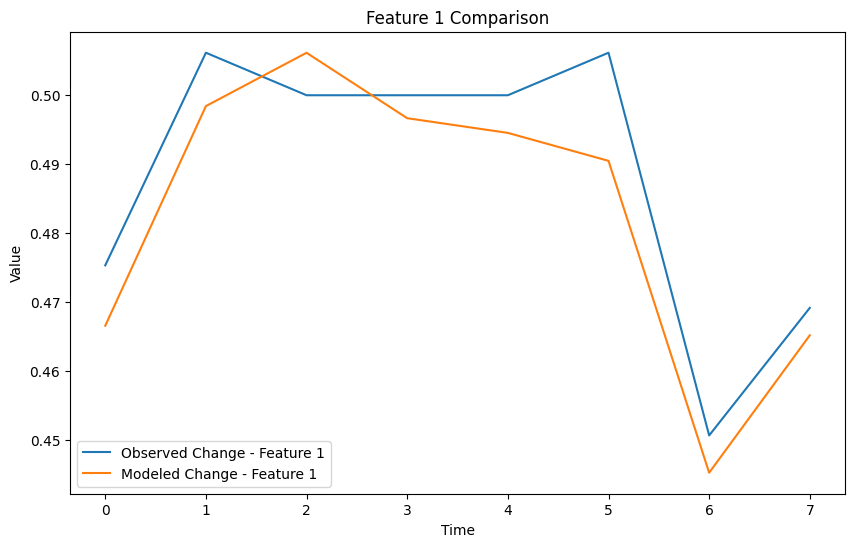

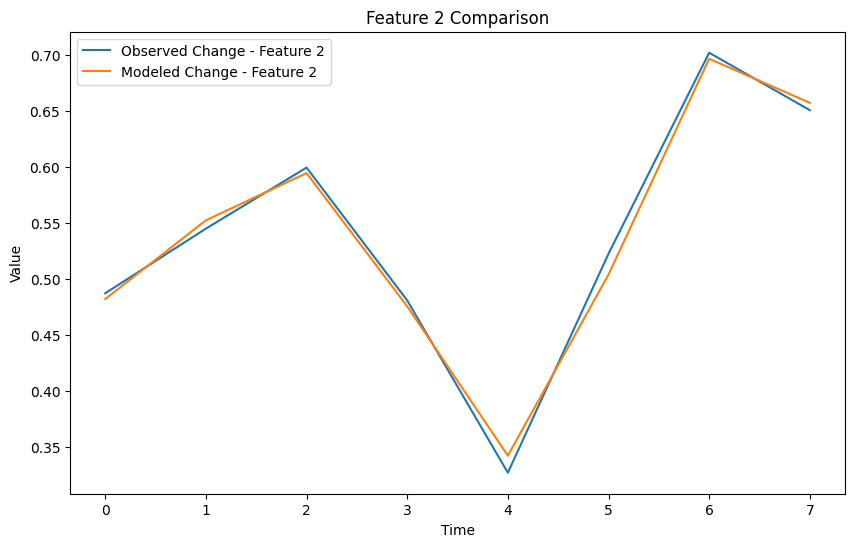

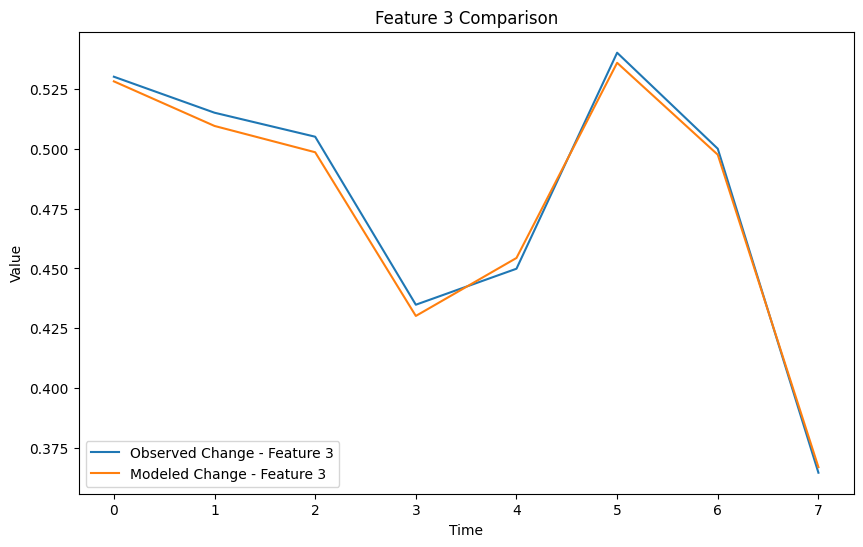

In [16]:
# Intialize Response Generator
generator = ResponseGenerator(cerberus_foresight, preparer.sliced_data, feature_indexes, preparer.max_change_dfs)

# Generate a response for a specific index
sel_index = 123
generator.generate_response(sel_index)

generator.plot_normalized_responses()

### Unscaled Response Review

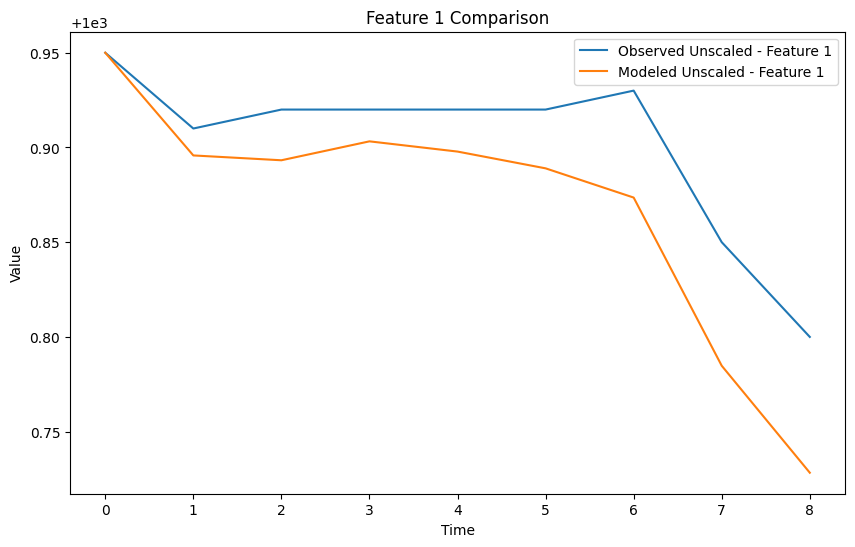

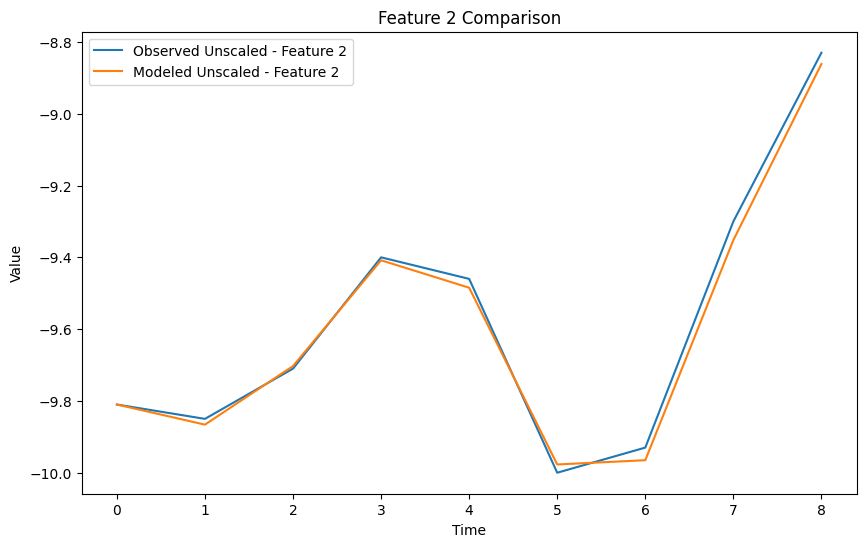

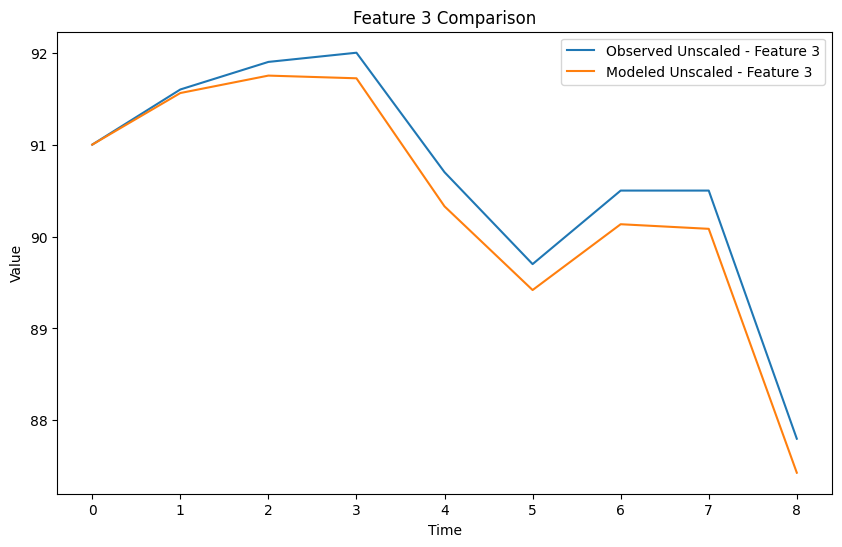

In [17]:
generator.plot_unscaled_responses(preparer.min_max_df, feature_indexes)